In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import read_data
import gensim
from sklearn.decomposition import PCA

In [2]:
data_folder = 'data'
nrows = None
prior = read_data(data_folder=data_folder, nrows=nrows, read_prior=True)
train = read_data(data_folder=data_folder, nrows=nrows, read_train=True)

In [3]:
train['product_id'] = train['product_id'].astype('str')
prior['product_id'] = prior['product_id'].astype('str')

In [4]:
train_products = train.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()
prior_products = prior.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()

In [5]:
products = pd.concat([train_products, prior_products])
print(products.shape)

(3346083, 2)


In [6]:
products.head()

,order_id,product_id
0,1,"[49302, 11109, 10246, 49683, 43633, 13176, 472..."
1,36,"[39612, 19660, 49235, 43086, 46620, 34497, 486..."
2,38,"[11913, 18159, 4461, 21616, 23622, 32433, 2884..."
3,96,"[20574, 30391, 40706, 25610, 27966, 24489, 39275]"
4,98,"[8859, 19731, 43654, 13176, 4357, 37664, 34065..."


In [7]:
max_num_prods= len(max(products['product_id'], key=len))
max_num_prods

145

In [8]:
# model training
model = gensim.models.Word2Vec(sentences=products['product_id'], min_count=2, vector_size=100, window=max_num_prods, workers=8)

In [9]:
# model.save('data/word2vec.model')

- `min_count` = 2 to ignore orders with only one product inside
- vector_size = 100, default size for the word vectors
- window =  max_num_prods because sequence of products added to cart are independent

In [10]:
model.wv.vectors.shape

(49583, 100)

In [11]:
len(model.wv.key_to_index.keys())

49583

In [12]:
model.wv

In [13]:
prods_embedding = pd.DataFrame(index=model.wv.key_to_index.keys(),
                              data=model.wv.vectors).rename_axis('product_id')
prods_embedding.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
product_id,,,,,,,,,,,,,,,,,,,,,
24852,0.711770,-1.344424,1.857387,-2.254449,-2.714099,-0.701070,-3.274530,-4.368392,-3.354698,-0.156490,...,0.599133,-3.653006,-0.805900,-0.627684,-1.684797,-0.889417,2.486539,3.284515,1.830542,0.155392
13176,3.109421,1.336914,2.143434,-1.958812,0.495347,0.846978,-2.824971,-5.158849,-2.652408,0.390102,...,-0.693990,-3.792375,-1.723678,-0.242754,-0.159515,-3.041061,-0.793552,4.775062,1.426485,0.549729
21137,-2.179251,0.629863,-1.342545,1.364112,3.244175,-0.079831,-5.902512,-7.720401,1.993463,-0.642954,...,-0.074592,-0.854819,-0.176400,-2.748030,1.237915,-3.735065,-2.593451,0.036997,3.144235,-4.043410


In [14]:
def get_product_names(dic, pid):
    products=pd.read_pickle('data/products.pickle')[['product_id', 'product_name', 'aisle', 'department']]
    products['product_id'] = products['product_id'].astype('str')
    print(products.loc[products['product_id']==pid])
    return pd.DataFrame(dic, columns=['product_id', 'similarity']).merge(products)

In [15]:
pid = '24852'
dic = model.wv.most_similar(pid, topn=5)
get_product_names(dic, pid)

      product_id product_name         aisle department
24851      24852       Banana  fresh fruits    produce


,product_id,similarity,product_name,aisle,department
0,13176,0.795506,Bag of Organic Bananas,fresh fruits,produce
1,37067,0.583988,Organic Banana,fresh fruits,produce
2,2951,0.478933,Chocolate Sea Salt Stars Shortbread Cookies,cookies cakes,snacks
3,4920,0.450094,Seedless Red Grapes,packaged vegetables fruits,produce
4,21271,0.445648,Folic Acid 800 mcg Vcaps,vitamins supplements,personal care


Top 5 products most similar to Banana are:
- Bag of Organic Bananas,
- Organic Banana
- Bartlett Pears
- Seedless Red Grapes
- Lentil & Quinoa Spaghetti

Because the model is trained based on orders of products, the top similar products can be alternatives for customers

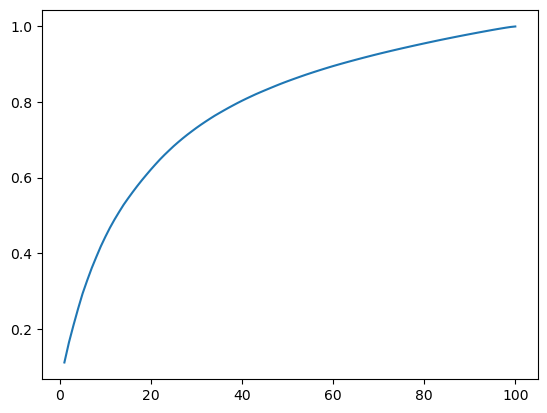

In [16]:
# to choose how many components we need
full_variance_explained = PCA().fit(prods_embedding.values).explained_variance_ratio_
plt.plot(range(1, prods_embedding.shape[1]+1, ), full_variance_explained.cumsum())

choose ~ 40 components to retain 80% of variance

In [17]:
var_retained = 0.8
n_components = np.argmax(np.cumsum(full_variance_explained) >= var_retained) + 1
n_components

40

In [18]:
# pca project data
pc = PCA(n_components, random_state=0).fit_transform(prods_embedding.values)
pc.shape

(49583, 40)

In [19]:
product_embedding = pd.DataFrame(index=prods_embedding.index, data=pc, columns=np.arange(pc.shape[1])).add_prefix('p_embedding_').reset_index()
product_embedding.head()

,product_id,p_embedding_0,p_embedding_1,p_embedding_2,p_embedding_3,p_embedding_4,p_embedding_5,p_embedding_6,p_embedding_7,p_embedding_8,...,p_embedding_30,p_embedding_31,p_embedding_32,p_embedding_33,p_embedding_34,p_embedding_35,p_embedding_36,p_embedding_37,p_embedding_38,p_embedding_39
0,24852,6.183636,-8.396371,-0.339550,7.175330,7.123689,5.784557,-0.661838,4.343639,1.433560,...,-0.051798,1.348206,1.298223,-1.322580,2.160367,-0.201206,0.909023,-1.364965,0.669517,0.939389
1,13176,12.342963,-2.028736,-0.140938,5.153012,1.869254,-1.002306,3.237164,3.399762,1.133663,...,-1.545215,1.139735,-1.193589,0.100404,1.808121,-1.894778,0.027095,1.256876,2.799036,-0.171440
2,21137,12.891898,-5.859041,1.124059,5.882640,5.210513,-1.226824,2.559977,2.780093,0.144179,...,-0.838079,1.790885,-1.198121,-0.568947,2.491989,-0.467473,1.057004,-0.195979,1.192585,-0.118172
3,21903,15.926896,-4.883900,-0.856111,-2.401511,3.152022,4.894067,0.183666,2.005176,2.025738,...,-0.451576,1.173494,0.701996,0.762366,1.314698,-0.051233,1.717769,-0.370698,0.184542,-0.211329
4,47209,16.934025,-0.522074,-1.188317,2.334150,1.822767,1.368582,2.037792,1.775352,0.632454,...,0.226348,-0.708388,-3.419651,-0.645408,0.880703,-1.700433,-1.508650,-1.333155,2.464445,-1.910323


In [20]:
# convert product
product_embedding.product_id = product_embedding.product_id.astype(int)

In [21]:
# product_embedding.to_pickle('data/product_embedding.pickle')